# Connect Forest Management Model with Forest Carbon Budget Model (without calibration)

Optionally, uninstall the ws3 package and replace it with a pointer to this local clone of the GitHub repository code (useful if you want ot tweak the source code for whatever reason).

## Set up Modelling Environment

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Import ws3 Module from Local Server
import ws3
#Show Module Path
ws3.__path__

['/media/data/home/yyan/.virtualenvs/yan/lib/python3.10/site-packages/ws3']

In [3]:
# Install libcbm Module from GitHub and Import it
install_libcbm = False
if install_libcbm:
    %pip install -U git+https://github.com/cat-cfs/libcbm_py.git@main
    import libcbm
    libcbm.__path__

## Create and Run `ForestModel` instance

In [4]:
# Install Pandas Library Version 2.0.3
%pip install pandas==2.0.3

Note: you may need to restart the kernel to use updated packages.


In [5]:
# Import Modules
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import ws3.forest, ws3.core
import time
import math

In [6]:
#Start Calculating the Running Time
Start = time.time()

In [7]:
# Set Basic Parameters
base_year = 2020
horizon = 20
period_length = 10
max_age = 1000
tvy_name = 'totvol'

In [8]:
# Creat Forest Model Instance for Timber Supply Area 24
fm = ws3.forest.ForestModel(model_name='tsa24',
                            model_path='data/woodstock_model_files_tsa24',
                            base_year=base_year,
                            horizon=horizon,
                            period_length=period_length,
                            max_age=max_age)
fm.import_landscape_section()
fm.import_areas_section()
fm.import_yields_section()
fm.import_actions_section()
fm.import_transitions_section()
fm.initialize_areas()
fm.add_null_action()
fm.reset_actions()

fm.grow()

In [9]:
# Flag 'harvest' as a harvesting action in the ws3 model
harvest_acode='harvest'
fm.actions[harvest_acode].is_harvest = True

In [10]:
# Import Modules
from util import compile_scenario, plot_scenario

(<Figure size 2000x500 with 4 Axes>,
 array([<Axes: title={'center': 'Harvested area'}, xlabel='Period', ylabel='Area (ha)'>,
        <Axes: title={'center': 'Harvested volume'}, xlabel='Period', ylabel='Volume (m3)'>,
        <Axes: title={'center': 'Growing Stock'}, xlabel='Period', ylabel='Volume (m3)'>,
        <Axes: title={'center': 'Ecosystem C stock'}, xlabel='Period', ylabel='Stock (ton)'>],
       dtype=object))

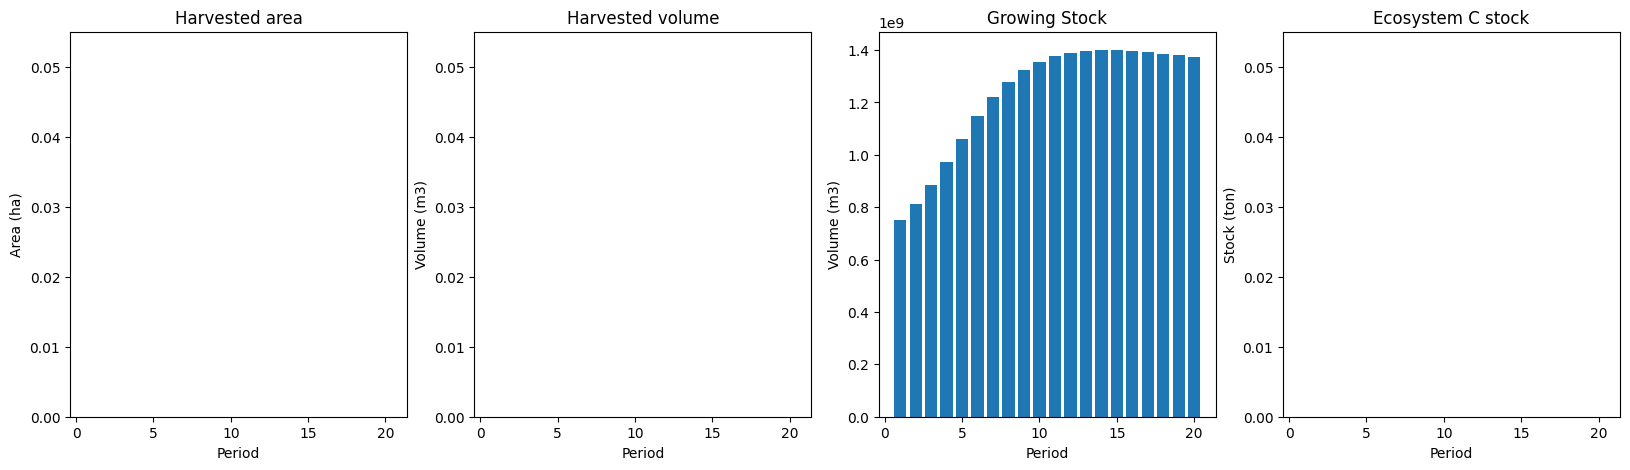

In [11]:
# Check the Forest Inventory of the Forest Model
df = compile_scenario(fm)
plot_scenario(df)

## Hard-link `ForestModel` to `libcbm`

In [12]:
# Import Modules
import libcbm
from util import run_cbm, cbm_report, plugin_c_curves

Prepare CBM input files

In [13]:
# Define Disturance Types
disturbance_type_mapping = [{'user_dist_type': 'harvest', 'default_dist_type': 'Clearcut harvesting without salvage'},
                            {'user_dist_type': 'fire', 'default_dist_type': 'Wildfire'}]
for dtype_key in fm.dtypes:
    fm.dt(dtype_key).last_pass_disturbance = 'fire' if dtype_key[2] == dtype_key[4] else 'harvest'

In [14]:
# sit_config, sit_tables = fm.to_cbm_sit(softwood_volume_yname='swdvol', 
#                                        hardwood_volume_yname='hwdvol', 
#                                        admin_boundary='British Columbia', 
#                                        eco_boundary='Montane Cordillera',
#                                        disturbance_type_mapping=disturbance_type_mapping)

In [15]:
# sit_inventory = fm._cbm_sit_inventory(softwood_volume_yname='swdvol', 
#                                       hardwood_volume_yname='hwdvol')

# sit_inventory.to_csv('data/libcbm_model_files_tsa24/sit_inventory.csv', index=False)

In [16]:
# Define Sit_config File
sit_config = {
                'mapping_config': {
                    'nonforest': None,
                    'species': {
                        'species_classifier': 'species',
                        'species_mapping': [
                            {'user_species': 'softwood', 'default_species': 'Softwood forest type'},
                            {'user_species': 'hardwood', 'default_species': 'Hardwood forest type'}
                        ]
                    },
                    'spatial_units': {
                        'mapping_mode': 'SingleDefaultSpatialUnit',
                        'admin_boundary': 'British Columbia',
                        'eco_boundary': 'Montane Cordillera'},
                    'disturbance_types': {
                        'disturbance_type_mapping': disturbance_type_mapping
                    }
                }
            }

In [17]:
# Define Sit Files
sit_classifiers = pd.read_csv('data/libcbm_model_files_tsa24/sit_classifiers.csv')
sit_disturbance_types = pd.read_csv('data/libcbm_model_files_tsa24/sit_disturbance_types.csv')
sit_age_classes = pd.read_csv('data/libcbm_model_files_tsa24/sit_age_classes.csv')
sit_inventory = pd.read_csv('data/libcbm_model_files_tsa24/sit_inventory.csv')
sit_yield = pd.read_csv('data/libcbm_model_files_tsa24/sit_yield.csv')
sit_events = pd.read_csv('data/libcbm_model_files_tsa24/sit_events.csv')
sit_transitions = pd.read_csv('data/libcbm_model_files_tsa24/sit_transitions.csv')

In [18]:
# Define Sit Tables
sit_tables = {'sit_classifiers': sit_classifiers,
              'sit_disturbance_types': sit_disturbance_types,
              'sit_age_classes': sit_age_classes,
              'sit_inventory': sit_inventory,
              'sit_yield': sit_yield,
              'sit_events': sit_events,
              'sit_transitions': sit_transitions}

Here are other two ways to generate sit tables. But they are only suitbale for small forest model since they take too much running time and memory

In [19]:
# Define Time Steps
n_steps = fm.horizon * fm.period_length

# Run CBM and Generate CBM 0utputs
cbm_output = run_cbm(sit_config, sit_tables, n_steps)

Emissions from all biomass components only resulting from fire disturbance, while these from all DOM pools resulting from annual decay processes and fire disturbance.

In [20]:
# Define Carbon Pools
biomass_pools = ['SoftwoodMerch','SoftwoodFoliage', 'SoftwoodOther', 'SoftwoodCoarseRoots','SoftwoodFineRoots',                        
                 'HardwoodMerch', 'HardwoodFoliage', 'HardwoodOther', 'HardwoodCoarseRoots', 'HardwoodFineRoots']
dom_pools = ['AboveGroundVeryFastSoil', 'BelowGroundVeryFastSoil', 'AboveGroundFastSoil', 'BelowGroundFastSoil',
             'MediumSoil', 'AboveGroundSlowSoil', 'BelowGroundSlowSoil', 'SoftwoodStemSnag', 'SoftwoodBranchSnag',
             'HardwoodStemSnag', 'HardwoodBranchSnag']
emissions_pools = ['CO2', 'CH4', 'CO', 'NO2']
products_pools = ['Products']
ecosystem_pools = biomass_pools + dom_pools
all_pools = biomass_pools + dom_pools + emissions_pools + products_pools

In [21]:
# Define Carbon Fluxes
annual_process_fluxes = [
    'DecayDOMCO2Emission',
    'DeltaBiomass_AG',
    'DeltaBiomass_BG',
    'TurnoverMerchLitterInput',
    'TurnoverFolLitterInput',
    'TurnoverOthLitterInput',
    'TurnoverCoarseLitterInput',
    'TurnoverFineLitterInput',
    'DecayVFastAGToAir',
    'DecayVFastBGToAir',
    'DecayFastAGToAir',
    'DecayFastBGToAir',
    'DecayMediumToAir',
    'DecaySlowAGToAir',
    'DecaySlowBGToAir',
    'DecaySWStemSnagToAir',
    'DecaySWBranchSnagToAir',
    'DecayHWStemSnagToAir',
    'DecayHWBranchSnagToAir'
]

npp_fluxes=[
    'DeltaBiomass_AG', 
    'DeltaBiomass_BG'
]
decay_emissions_fluxes = [
    'DecayVFastAGToAir',
    'DecayVFastBGToAir',
    'DecayFastAGToAir',
    'DecayFastBGToAir',
    'DecayMediumToAir',
    'DecaySlowAGToAir',
    'DecaySlowBGToAir',
    'DecaySWStemSnagToAir',
    'DecaySWBranchSnagToAir',
    'DecayHWStemSnagToAir',
    'DecayHWBranchSnagToAir'
]

disturbance_production_fluxes = [
    'DisturbanceSoftProduction',
    'DisturbanceHardProduction',
    'DisturbanceDOMProduction'   
]

disturbance_emissions_fluxes = [
    'DisturbanceMerchToAir',
    'DisturbanceFolToAir',
    'DisturbanceOthToAir',
    'DisturbanceCoarseToAir',
    'DisturbanceFineToAir',
    'DisturbanceVFastAGToAir',
    'DisturbanceVFastBGToAir',
    'DisturbanceFastAGToAir',
    'DisturbanceFastBGToAir',
    'DisturbanceMediumToAir',
    'DisturbanceSlowAGToAir',
    'DisturbanceSlowBGToAir',
    'DisturbanceSWStemSnagToAir',
    'DisturbanceSWBranchSnagToAir',
    'DisturbanceHWStemSnagToAir',
    'DisturbanceHWBranchSnagToAir'   
]

all_fluxes = [
    'DisturbanceCO2Production',
    'DisturbanceCH4Production',
    'DisturbanceCOProduction',
    'DisturbanceBioCO2Emission',
    'DisturbanceBioCH4Emission',
    'DisturbanceBioCOEmission',
    'DecayDOMCO2Emission',
    'DisturbanceSoftProduction',
    'DisturbanceHardProduction',
    'DisturbanceDOMProduction',
    'DeltaBiomass_AG',
    'DeltaBiomass_BG',
    'TurnoverMerchLitterInput',
    'TurnoverFolLitterInput',
    'TurnoverOthLitterInput',
    'TurnoverCoarseLitterInput',
    'TurnoverFineLitterInput',
    'DecayVFastAGToAir',
    'DecayVFastBGToAir',
    'DecayFastAGToAir',
    'DecayFastBGToAir',
    'DecayMediumToAir',
    'DecaySlowAGToAir',
    'DecaySlowBGToAir',
    'DecaySWStemSnagToAir',
    'DecaySWBranchSnagToAir',
    'DecayHWStemSnagToAir',
    'DecayHWBranchSnagToAir',
    'DisturbanceMerchToAir',
    'DisturbanceFolToAir',
    'DisturbanceOthToAir',
    'DisturbanceCoarseToAir',
    'DisturbanceFineToAir',
    'DisturbanceDOMCO2Emission',
    'DisturbanceDOMCH4Emission',
    'DisturbanceDOMCOEmission',
    'DisturbanceMerchLitterInput',
    'DisturbanceFolLitterInput',
    'DisturbanceOthLitterInput',
    'DisturbanceCoarseLitterInput',
    'DisturbanceFineLitterInput',
    'DisturbanceVFastAGToAir',
    'DisturbanceVFastBGToAir',
    'DisturbanceFastAGToAir',
    'DisturbanceFastBGToAir',
    'DisturbanceMediumToAir',
    'DisturbanceSlowAGToAir',
    'DisturbanceSlowBGToAir',
    'DisturbanceSWStemSnagToAir',
    'DisturbanceSWBranchSnagToAir',
    'DisturbanceHWStemSnagToAir',
    'DisturbanceHWBranchSnagToAir'
]

grossgrowth_ag = [
    "DeltaBiomass_AG",
    "TurnoverMerchLitterInput",
    "TurnoverFolLitterInput",
    "TurnoverOthLitterInput",
]

grossgrowth_bg = [
    "DeltaBiomass_BG",
    "TurnoverCoarseLitterInput",
    "TurnoverFineLitterInput",
]

product_flux = [
     "DisturbanceSoftProduction",
     "DisturbanceHardProduction",
     "DisturbanceDOMProduction",
]

GrossGrowth_AG = flux[[
        "DeltaBiomass_AG",
        "TurnoverMerchLitterInput",
        "TurnoverFolLitterInput",
        "TurnoverOthLitterInput",
        ]].sum(axis=1)

GrossGrowth_BG = flux[[
        "DeltaBiomass_BG",
        "TurnoverCoarseLitterInput",
        "TurnoverFineLitterInput",
        ]].sum(axis=1)

In [22]:
# Define Sum Carbon Pools and Sum Carbon Fluxes
pools = ecosystem_pools
fluxes = decay_emissions_fluxes + disturbance_emissions_fluxes
gross_growth = grossgrowth_ag + grossgrowth_bg

sum_pools = ['ecosystem', 'biomass', 'DOM']

,Biomass,DOM,Ecosystem,All_Emissions,Gross_Growth,Product,Product_flux,Stock_Change,Emissions - Growth,Stock Change - Product_flux
Year,,,,,,,,,,
0,4.673542e+08,9.258659e+08,1.393220e+09,0.000000e+00,0.000000e+00,9.694832e+07,0.0,0.000000e+00,0.000000e+00,0.000000e+00
1,4.706214e+08,9.239401e+08,1.394562e+09,1.943796e+07,2.077940e+07,9.694832e+07,0.0,-1.341447e+06,-1.341447e+06,-1.341447e+06
2,4.739248e+08,9.222316e+08,1.396156e+09,1.932936e+07,2.092419e+07,9.694832e+07,0.0,-1.594827e+06,-1.594827e+06,-1.594827e+06
3,4.772859e+08,9.207222e+08,1.398008e+09,1.924041e+07,2.109205e+07,9.694832e+07,0.0,-1.851634e+06,-1.851634e+06,-1.851634e+06
4,4.806945e+08,9.193964e+08,1.400091e+09,1.916871e+07,2.125156e+07,9.694832e+07,0.0,-2.082855e+06,-2.082855e+06,-2.082855e+06
...,...,...,...,...,...,...,...,...,...,...
196,7.046177e+08,1.104077e+09,1.808695e+09,2.327619e+07,2.354893e+07,9.694832e+07,0.0,-2.727415e+05,-2.727415e+05,-2.727415e+05
197,7.044444e+08,1.104524e+09,1.808968e+09,2.327252e+07,2.354579e+07,9.694832e+07,0.0,-2.732694e+05,-2.732694e+05,-2.732694e+05
198,7.042711e+08,1.104971e+09,1.809242e+09,2.326909e+07,2.354264e+07,9.694832e+07,0.0,-2.735468e+05,-2.735468e+05,-2.735468e+05


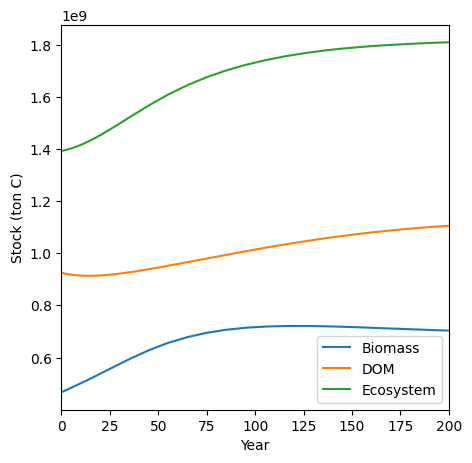

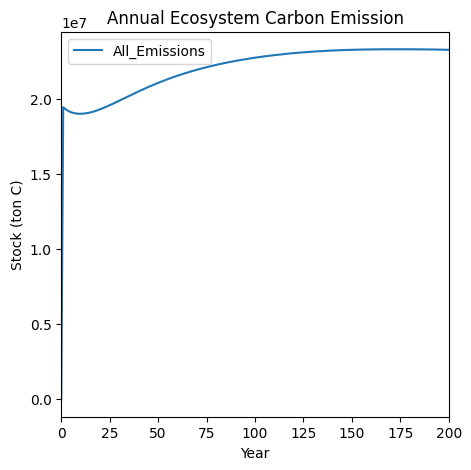

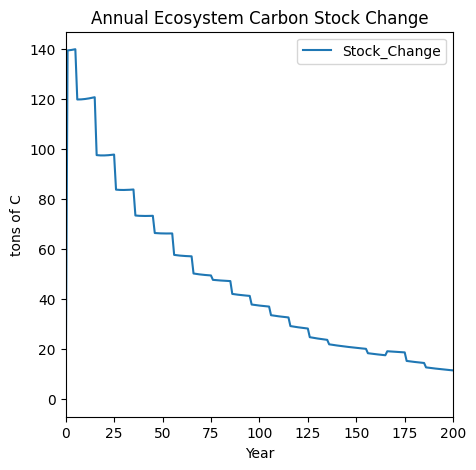

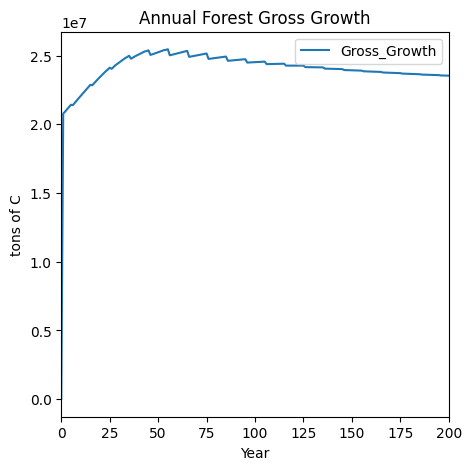

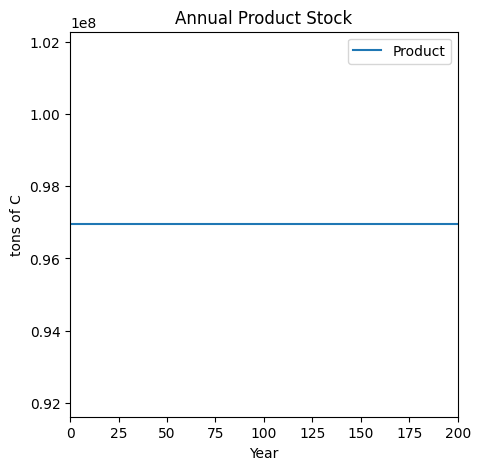

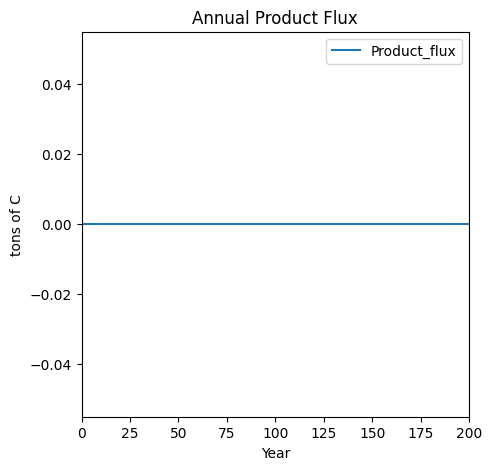

In [23]:
# Report Annual CBM Results
from util import cbm_report
cbm_report(fm, cbm_output, biomass_pools, dom_pools, fluxes, gross_growth, product_flux)

## Plug-in Carbon Yield Curves

In [24]:
# Read curves
c_curves_p = pd.read_pickle("curves/c_curves_p.pkl")
c_curves_f = pd.read_pickle("curves/c_curves_f.pkl") # Emission curves may be kind of broken

In [25]:
# Curvs Calibration
# c_curves_p = c_curves_p.iloc[:,-3:].apply(lambda x: x*1.03) # Calibrate the carbon yield curvest for total ecosystem pools
# c_curves_f = c_curves_f.iloc[:,-2:].apply(lambda x: x*1.03) # Calibrate the carbon yield curvest for net carbon flux

In [26]:
c_curves_p

SoftwoodMerch  SoftwoodFoliage  \
dtype_key                   timestep                                   
tsa24 0 2401000 100 2401000 0              0.000000         0.000000   
                            1              0.000100         0.142072   
                            2              0.000803         0.399931   
                            3              0.002724         0.575965   
                            4              0.006477         0.742157   
...                                             ...              ...   
tsa24 1 2403007 100 2423007 196          110.554996         9.315055   
                            197          110.630710         9.317758   
                            198          110.706420         9.320459   
                            199          110.782125         9.323159   
                            200          110.857825         9.325857   

                                      SoftwoodOther  SoftwoodCoarseRoots  \
dtype_key                   timestep                                       
tsa24 0 2401000 100 2401000 0              0.000000             0.000000   
                            1              0.000000             0.018159   
                            2              0.009712             0.052654   
                            3              0.182878             0.098251   
                            4              0.430046             0.153070   
...                                             ...                  ...   
tsa24 1 2403007 100 2423007 196           35.077570            31.728258   
                            197           35.089584            31.747243   
                            198           35.101597            31.766226   
                            199           35.113608            31.785206   
                            200           35.125619            31.804184   

                                      SoftwoodFineRoots  HardwoodMerch  \
dtype_key                   timestep                                     
tsa24 0 2401000 100 2401000 0                  0.000000            0.0   
                            1                  0.013403            0.0   
                            2                  0.038465            0.0   
                            3                  0.070817            0.0   
                            4                  0.108597            0.0   
...                                                 ...            ...   
tsa24 1 2403007 100 2423007 196                2.670114            0.0   
                            197                2.671205            0.0   
                            198                2.672296            0.0   
                            199                2.673388            0.0   
                            200                2.674481            0.0   

                                      HardwoodFoliage  HardwoodOther  \
dtype_key                   timestep                                   
tsa24 0 2401000 100 2401000 0                     0.0            0.0   
                            1                     0.0            0.0   
                            2                     0.0            0.0   
                            3                     0.0            0.0   
                            4                     0.0            0.0   
...                                               ...            ...   
tsa24 1 2403007 100 2423007 196                   0.0            0.0   
                            197                   0.0            0.0   
                            198                   0.0            0.0   
                            199                   0.0            0.0   
                            200                   0.0            0.0   

                                      HardwoodCoarseRoots  HardwoodFineRoots  \
dtype_key                   timestep                                           
tsa24 0 2401000 100 2401000 0                       

In [27]:
c_curves_f

DisturbanceCO2Production  \
dtype_key                   timestep                             
tsa24 0 2401000 100 2401000 0                              0.0   
                            1                              0.0   
                            2                              0.0   
                            3                              0.0   
                            4                              0.0   
...                                                        ...   
tsa24 1 2403007 100 2423007 196                            0.0   
                            197                            0.0   
                            198                            0.0   
                            199                            0.0   
                            200                            0.0   

                                      DisturbanceCH4Production  \
dtype_key                   timestep                             
tsa24 0 2401000 100 2401000 0                              0.0   
                            1                              0.0   
                            2                              0.0   
                            3                              0.0   
                            4                              0.0   
...                                                        ...   
tsa24 1 2403007 100 2423007 196                            0.0   
                            197                            0.0   
                            198                            0.0   
                            199                            0.0   
                            200                            0.0   

                                      DisturbanceCOProduction  \
dtype_key                   timestep                            
tsa24 0 2401000 100 2401000 0                             0.0   
                            1                             0.0   
                            2                             0.0   
                            3                             0.0   
                            4                             0.0   
...                                                       ...   
tsa24 1 2403007 100 2423007 196                           0.0   
                            197                           0.0   
                            198                           0.0   
                            199                           0.0   
                            200                           0.0   

                                      DisturbanceBioCO2Emission  \
dtype_key                   timestep                              
tsa24 0 2401000 100 2401000 0                               0.0   
                            1                               0.0   
                            2                               0.0   
                            3                               0.0   
                            4                               0.0   
...                                                         ...   
tsa24 1 2403007 100 2423007 196                             0.0   
                            197                             0.0   
                            198                             0.0   
                            199                             0.0   
                            200                             0.0   

                                      DisturbanceBioCH4Emission  \
dtype_key                   timestep                              
tsa24 0 2401000 100 2401000 0                               0.0   
                            1                               0.0   
                            2                               0.0   
                            3                               0.0   
                            4                               0.0   
...                                                         ...   
tsa24 1 2403007 100 2423007 196                             0.0   

In [28]:
# Plug carbon yield curves into forest model
plugin_c_curves(fm, c_curves_p, c_curves_f, pools=sum_pools, fluxes=['net_fluxes', 'total_emissions'])

found match for mask ('?', '?', '2401000', '?', '2401000')
found match for mask ('?', '?', '2401000', '?', '2401000')
found match for mask ('?', '?', '2401001', '?', '2401001')
found match for mask ('?', '?', '2401001', '?', '2401001')
found match for mask ('?', '?', '2401003', '?', '2401003')
found match for mask ('?', '?', '2401003', '?', '2401003')
found match for mask ('?', '?', '2401004', '?', '2401004')
found match for mask ('?', '?', '2401004', '?', '2401004')
found match for mask ('?', '?', '2401005', '?', '2401005')
found match for mask ('?', '?', '2401005', '?', '2401005')
found match for mask ('?', '?', '2401006', '?', '2401006')
found match for mask ('?', '?', '2401006', '?', '2401006')
found match for mask ('?', '?', '2402001', '?', '2402001')
found match for mask ('?', '?', '2402001', '?', '2402001')
found match for mask ('?', '?', '2402005', '?', '2402005')
found match for mask ('?', '?', '2402005', '?', '2402005')
found match for mask ('?', '?', '2402006', '?', '2402006

In [29]:
# Check if all carbon yield curves are plugged in well.
# fm.yields

(<Figure size 2000x500 with 4 Axes>,
 array([<Axes: title={'center': 'Harvested area'}, xlabel='Period', ylabel='Area (ha)'>,
        <Axes: title={'center': 'Harvested volume'}, xlabel='Period', ylabel='Volume (m3)'>,
        <Axes: title={'center': 'Growing Stock'}, xlabel='Period', ylabel='Volume (m3)'>,
        <Axes: title={'center': 'Ecosystem C stock'}, xlabel='Period', ylabel='Stock (ton)'>],
       dtype=object))

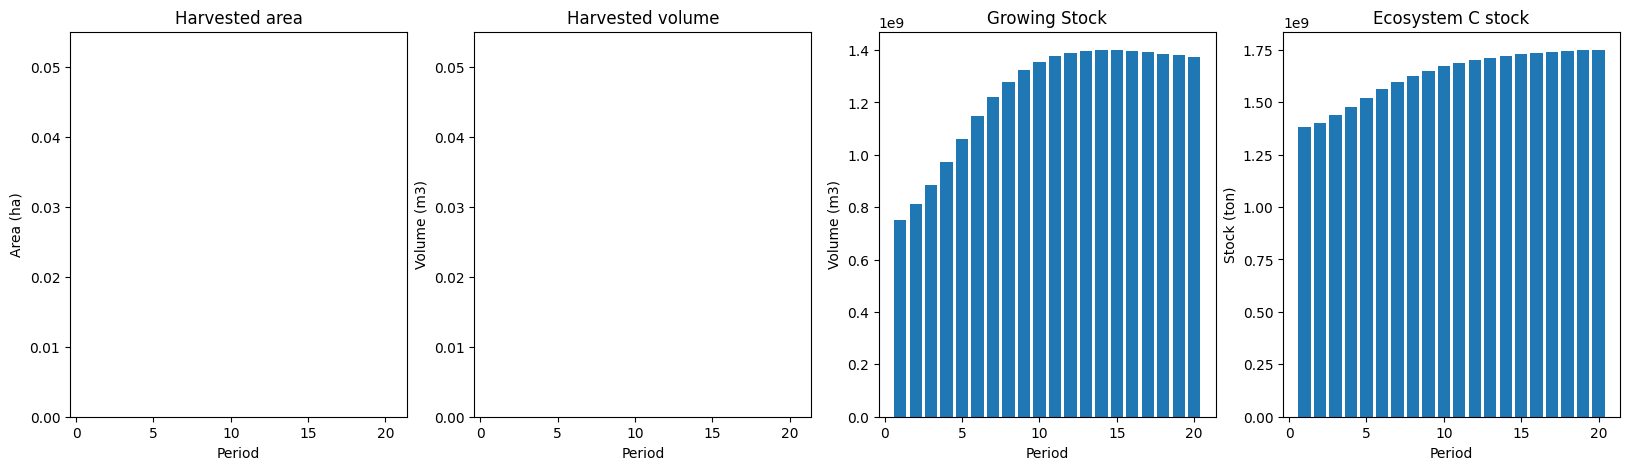

In [30]:
# Check the Forest Inventory of the ws3 Model without harvesting
df = compile_scenario(fm)
plot_scenario(df)

## Build Havrested Wood Product Carbon Model

In [31]:
#Define constants from product carbon estimation

# Define the product half-lives（>0.69)
half_life_solid_wood = 30
half_life_paper = 2

# Define the allocation distribution
proportion_solid_wood = 0.5

# Define the displacement factor 
displacement_factor = 2.2

In [32]:
def cmp_c_ss(fm, path, expr, yname, half_life_solid_wood=half_life_solid_wood, half_life_paper=half_life_paper, proportion_solid_wood=proportion_solid_wood, mask=None):
    """
    Compile objective function coefficient for total system carbon stock indicators (given ForestModel instance, 
    leaf-to-root-node path, and expression to evaluate).
    """
    result = 0.
    
    # Calculate decay rates based on half-lives
    k_solid_wood = math.log(2) / half_life_solid_wood  # Decay rate for solid wood products (30-year half-life)
    k_paper = math.log(2) / half_life_paper  # Decay rate for paper (2-year half-life)
    
    # Define the allocation distribution
    proportion_paper = 1 - proportion_solid_wood
    
    # wood density (Kennedy, 1965)
    wood_density = 460

    # carbon content
    carbon_content = 0.5
    
    # k_solid_wood = 0 # Decay rate for solid wood products (0-year half-life)
    # k_paper = 0 # Decay rate for paper (0-year half-life)
    
    product_stock_dict = {}  # Dictionary to track product stock for each node across iterations
    
    for t, n in enumerate(path, start=1):

        d = n.data()
        node_id = id(n)  # or another unique identifier specific to your application
        
        # Track the ecosystem carbon stock
        if mask and not fm.match_mask(mask, d['_dtk']): continue
        result = fm.inventory(t, yname, age=d['_age'], dtype_keys=[d['_dtk']])
        
        # Retrieve the last tuple of stocks from the dictionary
        last_stocks = next(reversed(product_stock_dict.values()), (0, 0))
        old_product_stock_solid_wood, old_product_stock_paper = last_stocks
        
        if fm.is_harvest(d['acode']):
            # Calculate new product stock
            new_product_carbon = fm.compile_product(t, expr, d['acode'], [d['dtk']], d['age'], coeff=False) * wood_density * carbon_content / 1000 # Convert kg to ton
            new_product_stock_solid_wood = new_product_carbon * proportion_solid_wood
            new_product_stock_paper = new_product_carbon * proportion_paper 

            # Apply decay to old stocks and add new stocks
            sum_product_stock_solid_wood = old_product_stock_solid_wood * (1 - k_solid_wood)**10 + new_product_stock_solid_wood * (1 - k_solid_wood)**10
            sum_product_stock_paper = old_product_stock_paper * (1 - k_paper)**10 + new_product_stock_paper * (1 - k_paper)**10
        
        else:
            # If not harvesting, simply apply decay to the old product stocks
            sum_product_stock_solid_wood = old_product_stock_solid_wood * (1 - k_solid_wood)
            sum_product_stock_paper = old_product_stock_paper * (1 - k_paper)
            
        # Update product_stock_dict with the new sum product stocks for this node
        product_stock_dict[node_id] = (sum_product_stock_solid_wood, sum_product_stock_paper)

        sum_product_stock = sum_product_stock_solid_wood + sum_product_stock_paper
        result += sum_product_stock
        
    return result

In [33]:
def cmp_c_se(fm, path, expr, yname, half_life_solid_wood=half_life_solid_wood, half_life_paper=half_life_paper, proportion_solid_wood=proportion_solid_wood, displacement_factor=displacement_factor, mask=None):
    """
    Compile objective function coefficient for net system carbon emission indicators (given ForestModel instance, 
    leaf-to-root-node path, and expression to evaluate).
    """
    result = 0.
    
   # Calculate decay rates based on half-lives
    k_solid_wood = math.log(2) / half_life_solid_wood  # Decay rate for solid wood products (30-year half-life)
    k_paper = math.log(2) / half_life_paper  # Decay rate for paper (2-year half-life)
    
    # Define the allocation distribution
    proportion_paper = 1 - proportion_solid_wood
    
    # wood density (Kennedy, 1965)
    wood_density = 460 #kg/m^3

    # carbon content
    carbon_content = 0.5
    
    product_stock_dict = {}  # Dictionary to track product stock for each node across iterations

    for t, n in enumerate(path, start=1):

        d = n.data()
        node_id = id(n)  # or another unique identifier specific to your application
        
        # Track the ecosystem carbon stock change
        if mask and not fm.match_mask(mask, d['_dtk']): continue
        result += (fm.inventory(t-1, yname, age=d['_age'], dtype_keys=[d['_dtk']])-fm.inventory(t, yname, age=d['_age'], dtype_keys=[d['_dtk']]))*44/12
        
        # Retrieve the last tuple of stocks from the dictionary
        last_stocks = next(reversed(product_stock_dict.values()), (0, 0))
        old_product_stock_solid_wood, old_product_stock_paper = last_stocks
        
        if fm.is_harvest(d['acode']):
            # Calculate new product stock
            new_product_stock = fm.compile_product(t, expr, d['acode'], [d['dtk']], d['age'], coeff=False) * wood_density * carbon_content / 1000 # Convert kg to ton
            new_product_stock_solid_wood = new_product_stock * proportion_solid_wood
            new_product_stock_paper = new_product_stock * proportion_paper 

            # Apply decay to old stocks and add new stocks
            sum_product_stock_solid_wood = old_product_stock_solid_wood * (1 - k_solid_wood)**10 + new_product_stock_solid_wood * (1 - k_solid_wood)**10
            sum_product_stock_paper = old_product_stock_paper * (1 - k_paper)**10 + new_product_stock_paper * (1 - k_paper)**10
            
            sum_product_emission_solid_wood = (old_product_stock_solid_wood * k_solid_wood**10 + new_product_stock_solid_wood * k_solid_wood**10)*44/12
            sum_product_emission_paper = (old_product_stock_paper * k_paper**10 + new_product_stock_paper * k_paper**10)*44/12

            # Update product_stock_dict with the new sum product stocks for this node
            product_stock_dict[node_id] = (sum_product_stock_solid_wood, sum_product_stock_paper)
            
            sum_product_emission = sum_product_emission_solid_wood + sum_product_emission_paper # Convert C to CO2
            
            substitution_effect = new_product_stock_solid_wood*displacement_factor*44/12*-1 # negative emission aviod by displacing high GHG-intensive materials and products with HWPs 
           
            result -= new_product_stock*44/12 # Aviod double-accounting the HWPs carbon emissions
            result += sum_product_emission
            result += substitution_effect
        
        else:
            # If not harvesting, simply apply decay to the old product stocks
            sum_product_stock_solid_wood = old_product_stock_solid_wood * (1 - k_solid_wood)**10
            sum_product_stock_paper = old_product_stock_paper * (1 - k_paper)**10
            
            sum_product_emission_solid_wood = old_product_stock_solid_wood * k_solid_wood*44/12
            sum_product_emission_paper = old_product_stock_paper * k_paper*44/12

            # Update product_stock_dict with the new sum product stocks for this node
            product_stock_dict[node_id] = (sum_product_stock_solid_wood, sum_product_stock_paper)

            sum_product_emission = sum_product_emission_solid_wood + sum_product_emission_paper
            result += sum_product_emission

    return result

In [34]:
# Build the function to track and report total system carbon stock

In [35]:
def track_system_stock(fm, half_life_solid_wood=half_life_solid_wood, half_life_paper=half_life_paper, proportion_solid_wood=proportion_solid_wood):
    
    product_stock_dict = {}
    solid_wood_stock_list = []
    paper_stock_list = []
    product_stock_list = []
    ecosystem_stock_list = []
    system_stock_list = []

    # Calculate decay rates based on half-lives
    k_solid_wood = math.log(2) / half_life_solid_wood
    k_paper = math.log(2) / half_life_paper

    # Define the allocation distribution
    proportion_paper = 1-proportion_solid_wood

    # Constants
    wood_density = 460 #(Kennedy, 1965)
    carbon_content = 0.5

    for period in fm.periods:
        # Get old product stocks
        last_stocks = next(reversed(product_stock_dict.values()), (0, 0))
        old_product_stock_solid_wood, old_product_stock_paper = last_stocks

        # Calculate new product stocks
        new_product_stock = fm.compile_product(period, 'totvol * 0.85', acode='harvest')* wood_density * carbon_content / 1000 # Convert kg to ton
        new_product_stock_solid_wood = new_product_stock * proportion_solid_wood
        new_product_stock_paper = new_product_stock * proportion_paper 

        # Apply decay to all stocks within the same period they're produced
        sum_product_stock_solid_wood = (old_product_stock_solid_wood + new_product_stock_solid_wood) * (1 - k_solid_wood)**10
        sum_product_stock_paper = (old_product_stock_paper + new_product_stock_paper) * (1 - k_paper)**10

        # Update product_stock_dict for this period
        product_stock_dict[period] = (sum_product_stock_solid_wood, sum_product_stock_paper)

        # Calculate total system carbon stock
        sum_product_stock = sum_product_stock_solid_wood + sum_product_stock_paper
        ecosystem_stock = fm.inventory(period, 'ecosystem')
        total_system_stock = ecosystem_stock + sum_product_stock

        # Update stock lists for this period
        solid_wood_stock_list.append(sum_product_stock_solid_wood)
        paper_stock_list.append(sum_product_stock_paper)
        product_stock_list.append(sum_product_stock)
        ecosystem_stock_list.append(ecosystem_stock)
        system_stock_list.append(total_system_stock)

    # Prepare data for plotting
    data = {
        'period': fm.periods,
        'solid_wood': solid_wood_stock_list,
        'paper': paper_stock_list,
        'sum_product': product_stock_list,
        'ecosystem': ecosystem_stock_list,
        'system': system_stock_list
    }

    df = pd.DataFrame(data)

    # Plotting
    fig, ax = plt.subplots(1, 5, figsize=(16, 4))  # Adjusted for 5 subplots
    ax[0].bar(df.period, df.solid_wood)
    ax[0].set_title('Solid Wood Product C Stock')
    ax[1].bar(df.period, df.paper)
    ax[1].set_title('Paper Product C Stock')
    ax[2].bar(df.period, df.sum_product)
    ax[2].set_title('Total Product C Stock')
    ax[3].bar(df.period, df.ecosystem)
    ax[3].set_title('Ecosystem C Stock')
    ax[4].bar(df.period, df.system)
    ax[4].set_title('Total System C Stock')

    for a in ax:
        a.set_ylim(None, None)
        a.set_xlabel('Period')
        a.set_ylabel('Stock (tons)')

    plt.tight_layout()
    return fig, ax, df

In [36]:
def track_system_emission(fm, half_life_solid_wood=half_life_solid_wood, half_life_paper=half_life_paper, proportion_solid_wood=proportion_solid_wood, displacement_factor=displacement_factor):
    
    product_stock_dict = {}
    solid_wood_emission_list = []
    paper_emission_list = []
    product_emission_list = []
    ecosystem_emission_list = []
    system_emission_list = []

    # Calculate decay rates based on half-lives
    k_solid_wood = math.log(2) / half_life_solid_wood
    k_paper = math.log(2) / half_life_paper

    # Define the allocation distribution
    proportion_paper = 1-proportion_solid_wood

    # Constants
    wood_density = 460 #(Kennedy, 1965)
    carbon_content = 0.5
    
    for period in fm.periods:
        # Get old product emissions
        last_stocks = next(reversed(product_stock_dict.values()), (0, 0))
        old_product_stock_solid_wood, old_product_stock_paper = last_stocks

        # Calculate new product emissions
        new_product_stock = fm.compile_product(period, 'totvol * 0.85', acode='harvest') * wood_density * carbon_content / 1000 # convert the unit from kg to ton
        new_product_stock_solid_wood = new_product_stock * proportion_solid_wood
        new_product_stock_paper = new_product_stock * proportion_paper

        # Apply decay to all emissions within the same period they're produced
        sum_product_stock_solid_wood = (old_product_stock_solid_wood + new_product_stock_solid_wood) * (1 - k_solid_wood)
        sum_product_stock_paper = (old_product_stock_paper + new_product_stock_paper) * (1 - k_paper)

        sum_product_emission_solid_wood = (old_product_stock_solid_wood + new_product_stock_solid_wood) * k_solid_wood * 44 / 12 # Convert C to CO2
        sum_product_emission_paper = (old_product_stock_paper + new_product_stock_paper) * k_paper * 44 / 12 # Convert C to CO2
        
        # Update product_emission_dict for this period
        product_stock_dict[period] = (sum_product_stock_solid_wood, sum_product_stock_paper)

        # Calculate total system carbon emission
        sum_product_emission = sum_product_emission_solid_wood + sum_product_emission_paper
        ecosystem_emission = (fm.inventory(period-1, 'ecosystem') - fm.inventory(period, 'ecosystem') - new_product_stock) * 44 / 12 if period > 0 else 0
        substitution_effect = new_product_stock_solid_wood*displacement_factor*44/12*-1 # negative emission aviod by displacing high GHG-intensive materials and products with HWPs 
        total_system_emission = ecosystem_emission + sum_product_emission + substitution_effect
        
        # Update stock lists for this period
        solid_wood_emission_list.append(sum_product_emission_solid_wood)
        paper_emission_list.append(sum_product_emission_paper)
        product_emission_list.append(sum_product_emission)
        ecosystem_emission_list.append(ecosystem_emission)
        system_emission_list.append(total_system_emission)

    # Prepare data for plotting
    data = {
        'period': fm.periods,
        'solid_wood': solid_wood_emission_list,
        'paper': paper_emission_list,
        'sum_product': product_emission_list,
        'ecosystem': ecosystem_emission_list,
        'system': system_emission_list
    }

    df = pd.DataFrame(data)

    # Plotting
    fig, ax = plt.subplots(1, 5, figsize=(16, 4))  # Adjusted for 5 subplots
    ax[0].bar(df.period, df.solid_wood)
    ax[0].set_title('Solid Wood Product CO2 Emission')
    ax[1].bar(df.period, df.paper)
    ax[1].set_title('Paper Product CO2 Emission')
    ax[2].bar(df.period, df.sum_product)
    ax[2].set_title('Total Product CO2 Emission')
    ax[3].bar(df.period, df.ecosystem)
    ax[3].set_title('Ecosystem CO2 Emission')
    ax[4].bar(df.period, df.system)
    ax[4].set_title('Total System CO2 Emission')

    for a in ax:
        a.set_ylim(None, None)
        a.set_xlabel('Period')
        a.set_ylabel('Emission (tons)')

    plt.tight_layout()
    return fig, ax, df

## Implement Optimization-based Action Scheduling

In [37]:
#Install Module
%pip install gurobipy

Note: you may need to restart the kernel to use updated packages.


In [38]:
#Import Module
import gurobipy as grb

Add a "null" action to the model for the optimization functions to work correctly.

In [39]:
#Add a Null Action
fm.add_null_action()

Define base and other scenarios below. You can change you objective functions and constraints by modifying the scenarios directly.

In [40]:
def cmp_c_z(fm, path, expr):
    """
    Compile objective function coefficient (given ForestModel instance, 
    leaf-to-root-node path, and expression to evaluate).
    """
    result = 0.
    for t, n in enumerate(path, start=1):
        d = n.data()
        if fm.is_harvest(d['acode']):
            result += fm.compile_product(t, expr, d['acode'], [d['dtk']], d['age'], coeff=False)
            # print('t')
            # print(result)
    return result

def cmp_c_cflw(fm, path, expr, mask=None): # product, all harvest actions
    """
    Compile flow constraint coefficient for product indicator (given ForestModel 
    instance, leaf-to-root-node path, expression to evaluate, and optional mask).
    """
    result = {}
    for t, n in enumerate(path, start=1):
        d = n.data()
        if mask and not fm.match_mask(mask, d['dtk']): continue
        if fm.is_harvest(d['acode']):
            result[t] = fm.compile_product(t, expr, d['acode'], [d['dtk']], d['age'], coeff=False)
    return result


def cmp_c_caa(fm, path, expr, acodes, mask=None): # product, named actions
    """
    Compile constraint coefficient for product indicator (given ForestModel 
    instance, leaf-to-root-node path, expression to evaluate, list of action codes, 
    and optional mask).
    """
    result = {}
    for t, n in enumerate(path, start=1):
        d = n.data()
        if mask and not fm.match_mask(mask, d['dtk']): continue
        if d['acode'] in acodes:
            result[t] = fm.compile_product(t, expr, d['acode'], [d['dtk']], d['age'], coeff=False)
    return result


def cmp_c_ci(fm, path, yname, mask=None): # product, named actions
    """
    Compile constraint coefficient for inventory indicator (given ForestModel instance, 
    leaf-to-root-node path, expression to evaluate, and optional mask).
    """
    result = {}
    for t, n in enumerate(path, start=1):
        d = n.data()
        if mask and not fm.match_mask(mask, d['_dtk']): continue
        result[t] = fm.inventory(t, yname=yname, age=d['_age'], dtype_keys=[d['_dtk']]) 
        #result[t] = fm.inventory(t, yname=yname, age=d['age'], dtype_keys=[d['dtk']]) 
    return result

In [41]:
def cmp_c_i(fm, path, yname, mask=None): # product, named actions
    """
    Compile objective function coefficient for inventory indicators (given ForestModel instance, 
    leaf-to-root-node path, and expression to evaluate).
    """
    result = 0.
    for t, n in enumerate(path, start=1):
        d = n.data()
        if mask and not fm.match_mask(mask, d['_dtk']): continue
        result = fm.inventory(t, yname=yname, age=d['_age'], dtype_keys=[d['_dtk']])
        #result[t] = fm.inventory(t, yname=yname, age=d['age'], dtype_keys=[d['dtk']])
    return result

In [42]:
def cmp_c_id(fm, path, yname, mask=None): # product, named actions
    """
    Compile objective function coefficient for inventory indicators (given ForestModel instance, 
    leaf-to-root-node path, and expression to evaluate).
    """
    result = 0.
    for t, n in enumerate(path, start=1):
        d = n.data()
        if mask and not fm.match_mask(mask, d['_dtk']): continue
        if t==1:
            result = 0.
        else:
            result += (fm.inventory(t, yname, age=d['_age'], dtype_keys=[d['_dtk']])-fm.inventory(t-1, yname, age=d['_age'], dtype_keys=[d['_dtk']]))
        #result[t] = fm.inventory(t, yname=yname, age=d['age'], dtype_keys=[d['dtk']])
    return result

Define a generic base scenario function, and link it to a dispatch function keyed on scenario name string (e.g., `base`). 

Note how we use `functools.partial` to specialize the more general functions defined above for use in the `coeff_funcs` arg of `ForestModel.add_problem`. Otherwise we would have to define an entirely new function each time we defined a slightly different objective or constraint in one of our scenarios, which would get tedious and messy. The tedium and mess would be more evident if we had a large number of alternative scenarios defined in the same notebook (which we do not here, but use your imagination). 

Note also that the expected data structures for the various args to `ForestModel.add_problem` must be matched exactly or `ws3` will likely crash somewhere in one of the series of complicated private optimization model-building methods that get called from `ForestModel.add_problem`. You _should not_ have to unpack the exact logic of this model-building code to figure out why your model is crashing... it really is quite complicated and hard to follow. If you model is crashing there, you probably fed invalid (or incorrectly structured) args to `ForestModel.add_problem`. Carefully review the structure and values of your args to find the problem. I left some notes below (and some comments in the `_gen_scen_base` function code) to help clarify the expected arg structure, and will work on expanding the docstrings in the `ws3` source code so this is less obscure going forward.

I also had to patch the `ws3` code in two places so that it would "grow" correctly with the model set up to use _years_ as the age unit. For some reason the latest `dev` branch of `ws3` on GitHub was in some sort of intermediate state between using _periods_ and _years_ as the age unit. Originally `ws3` was implemented to import and simulate legacy Woodstock model input datasets, so it used _periods_ as the age unit (like Woodstock). At some point I think I hastily patched `ws3` to use _years_ as the age unit to make it work with `spades_ws3` for specific projects that needed to get done and delivered... if I recall we set the period length to 1 year for all those projects so it "just worked", but now we have a bit of a mess. Oops. Ultimately, I will need to revert `ws3` back to using Woodstock-compatible _period_ age unit (but make sure that the `spatial` module can still spatially and temporally disaggregate the aspatial periodic solutions from the Model I LP optimization problems into year-length time slices (maybe with age optionally expressed in years in output from this, for compatibility with downstream linked models like `SpaDES`). This is just a side-effect of many iterations of re-purposing `ws3` to work in a long (ad hoc) sequence of real research projects that had very specific input and output data specs. It is actually remarkable that `ws3` is not _more_ of a mess than it currently is, given the history and essentially null development budget. Use

`ForestModel.add_problem` arg specs are described below.

`name`: String. Used as key to store `Problem` instances in a dict in the `ForestModel` instanace, so make sure it is unique within a given model or you will overwrite dict values (assuming you want to stuff multiple problems, and their solutions, into your model at the same time). 
    
`coeff_funcs`: Dict of function references, keyed on _row name_ strings. These are the functions that generate the LP optimization problem matrix coefficients (for the objective function and constraint rows). This one gets complicated, and is a likely source of bugs. Make sure the row name key strings are all unique or you will make a mess. You can name the constraint rows anything you want, but the objective function row has to be named `z`. All coefficient functions must accept exactly two args, in this order: a `ws3.forest.ForestModel` instance and a `ws3.common.Path` instance. The `z` coefficient function is special in that it must return a single float value. All other (i.e., constraint) coefficient functions just return a dict of floats, keyed on period ints (can be sparse, i.e., not necessary to include key:value pairs in output dict if value is 0.0). It is useful (but not necessary) to use `functools.partial` to specialize a smaller number of more general function definitions (with more args, that get "locked down" and hidden by `partial`) as we have done in the example in this notebook.

`cflw_e`: Dict of `(dict, int)` tuples, keyed on _row name_ strings (must match _row name_ key values used to define coefficient functions for flow constraints in `coeff_func` dict), where the int:float dict embedded in the tuple defines epsilon values keyed on periods (must include all periods, even if epsilon value is always the same). See example below. 

```
{
  'cflw_acut':({1:0.01, 2:0.01, ..., 10:0.01}, 1),
  'cflw_vcut':({1:0.05, 2:0.05, ..., 10:0.05}, 1)
}
```

`cgen_data`: Dict of dict of dicts. The outer-level dict is keyed on _row name_ strings (must match row names used in `coeff_funcs`. The middle second level of dicts always has keys `'lb'` and `'ub'`, and the inner level of dicts specifies lower- and upper-bound general constraint RHS (float) values, keyed on period (int).

`acodes`: List of strings. Action codes to be included in optimization problem formulation (actions must defined in the `ForestModel` instance, but can be only a subset).

`sense`: Must be one of `ws3.opt.SENSE_MAXIMIZE` or `ws3.opt.SENSE_MINIMIZE`.

`mask`: Tuple of strings constituting a valid mask for your `ForestModel` instance. Can be `None` if you do not want to filter `DevelopmentType` instances.

In [43]:
##### Define Gen_scenario Function
def gen_scenario(fm, name='base', util=0.85, harvest_acode='harvest',
                 cflw_ha={}, cflw_hv={}, 
                 cgen_ha={}, cgen_hv={}, 
                 cgen_gs={}, tvy_name='totvol', cp_name='ecosystem', cf_name='total_emissions', obj_mode='max_hv', mask=None):
    
    from functools import partial
    import numpy as np
    coeff_funcs = {}
    cflw_e = {}
    cgen_data = {}
    acodes = ['null', harvest_acode] # define list of action codes
    vexpr = '%s * %0.2f' % (tvy_name, util) # define volume expression
    
    if obj_mode == 'max_hv': # maximize harvest volume
        sense = ws3.opt.SENSE_MAXIMIZE 
        zexpr = vexpr
    elif obj_mode == 'min_hv': # maximize harvest volume
        sense = ws3.opt.SENSE_MINIMIZE 
        zexpr = vexpr
    else:
        raise ValueError('Invalid obj_mode: %s' % obj_mode)
        
    # coeff_funcs['z'] = partial(cmp_c_i, yname=cf_name) # define objective function coefficient function for inventory data
    # coeff_funcs['z'] = partial(cmp_c_id, yname=cf_name) # define objective function coefficient function for inventory change data
    coeff_funcs['z'] = partial(cmp_c_z, expr=vexpr) # define objective function coefficient function for havrest volume
    # coeff_funcs['z'] = partial(cmp_c_ss, expr=vexpr, yname=cp_name) # define objective function coefficient function for total system carbon stock
    # coeff_funcs['z'] = partial(cmp_c_se, expr=vexpr, yname=cp_name) # define objective function coefficient function for net system carbon emission
    T = fm.periods
    if cflw_ha: # define even flow constraint (on harvest area)
        cname = 'cflw_ha'
        coeff_funcs[cname] = partial(cmp_c_caa, expr='1.', acodes=[harvest_acode], mask=None) 
        cflw_e[cname] = cflw_ha
    if cflw_hv: # define even flow constraint (on harvest volume)
        cname = 'cflw_hv'
        coeff_funcs[cname] = partial(cmp_c_caa, expr=vexpr, acodes=[harvest_acode], mask=None) 
        # cflw_e[cname] = cflw_hv         
    if cgen_ha: # define general constraint (harvest area)
        cname = 'cgen_ha'
        coeff_funcs[cname] = partial(cmp_c_caa, expr='1.', acodes=[harvest_acode], mask=None) 
        cgen_data[cname] = cgen_ha
    if cgen_hv: # define general constraint (harvest volume)
        cname = 'cgen_hv'
        coeff_funcs[cname] = partial(cmp_c_caa, expr=vexpr, acodes=[harvest_acode], mask=None) 
        cgen_data[cname] = cgen_hv
    if cgen_gs: # define general constraint (growing stock)
        cname = 'cgen_gs'
        coeff_funcs[cname] = partial(cmp_c_ci, yname=tvy_name, mask=None)
        cgen_data[cname] = cgen_gs
    # if cgen_cp: # define general constraint (carbon pools)
    #     cname = 'cgen_cp'
    #     coeff_funcs[cname] = partial(cmp_c_ci, yname=cp_name, mask=None)
    #     cgen_data[cname] = cgen_cp
    # if cgen_cf: # define general constraint (carbon fluxes)
    #     cname = 'cgen_cf'
    #     coeff_funcs[cname] = partial(cmp_c_ci, yname=cf_name, mask=None)
    #     cgen_data[cname] = cgen_cf
    return fm.add_problem(name, coeff_funcs, cflw_e, cgen_data=cgen_data, acodes=acodes, sense=sense, mask=mask)

In [44]:
# Define Run_scenario Function
def run_scenario(fm, scenario_name='base'):
    cflw_ha = {}
    cflw_hv = {}
    cgen_ha = {}
    cgen_hv = {}
    cgen_gs = {}
    # cgen_cp = {}
    # cgen_cf = {}
    
    # define harvest area and harvest volume even-flow constraints
    cflw_ha = ({p:0.05 for p in fm.periods}, 1)
    cflw_hv = ({p:0.05 for p in fm.periods}, 1)
    
    in_gs = 750290200. #initial growing stock volume
    AAC = 6935023. # AAC of TSA24

    if scenario_name == 'single_cut': 
        # Base scenario
        print('running scenario')
        cgen_hv = {'lb':{x:0.0 for x in [1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]}, 'ub':{x:0.0 for x in [1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]}} #Achieve the Annual Allowable Cut
        # cgen_gs = {'lb':{10:in_gs*0.9}, 'ub':{10:in_gs*2}} #Not less than 90% of initial growing stock
        # cgen_gs = {'lb':{10:in_gs*0.9}, 'ub':{10:in_gs*2}} #Not less than 90% of initial growing stock
        # cgen_hv = {'lb':{x:AAC*0.5 for x in fm.periods}, 'ub':{x:AAC*1000 for x in fm.periods}} #Achieve the Annual Allowable Cu
        # cgen_hv = {'lb':{10:in_gs*10}, 'ub':{10:in_gs*10+1}}
    elif scenario_name == 'base': 
        # Base scenario
        print('running base scenario')
        cgen_gs = {'lb':{x:in_gs*0.9 for x in range(0,21)}, 'ub':{x:in_gs*2 for x in range(0,21)}} #Not less than 90% of initial growing stock
        cgen_hv = {'lb':{x:AAC*0.9 for x in range(0,21)}, 'ub':{x:AAC for x in range(0,21)}} #Maintain the Annual Allowable Cut
    elif scenario_name == 'base_m': 
        # Base scenario
        print('running maxmizie harvest scenario')
        # cgen_gs = {'lb':{x:in_gs*0.9 for x in range(0,21)}, 'ub':{x:in_gs*100 for x in range(0,21)}} #Not less than 90% of initial growing stock
        # cgen_hv = {'lb':{20:AAC-1}, 'ub':{20:AAC}} #Achieve the Annual Allowable Cut
    elif scenario_name == 'base_c': 
        # Cabron indicators constraints
        print('running base scenario with even-flow constraints')
        cgen_gs = {'lb':{10:in_gs*0.9}, 'ub':{10:in_gs*2}} #Not less than 90% of initial growing stock
        cgen_hv = {'lb':{1:AAC*0.5}, 'ub':{1:AAC*2}}  #Not less than 10% of annual allowable cut
        # cgen_cf = {'lb':{10:in_cf}, 'ub':{10:in_cf*1.1}} #Not more than 110% of initial total ecosystem carbon stock
    elif scenario_name == 'reduce_10%_AAC': 
        # Reduce 10% of harvest volume from base scenario
        print('running base scenario reduced 10% of AAC')
        cgen_gs = {'lb':{10:in_gs*0.9}, 'ub':{10:in_gs*0.9+1}}#Not less than 90% of initial growing stock
        cgen_hv = {'lb':{1:AAC*0.9-1}, 'ub':{1:AAC*0.9}}    
    elif scenario_name == 'reduce_20%_AAC': 
        # Reduce 20% of harvest volume from base scenario
        print('running base scenario reduced 20% of AAC')
        cgen_gs = {'lb':{10:in_gs*0.9}, 'ub':{10:in_gs*0.9+1}} #Not less than 90% of initial growing stock
        cgen_hv = {'lb':{1:AAC*0.8-1}, 'ub':{1:AAC*0.8}}   
    elif scenario_name == 'increase_10%_AAC': 
        # Increase 10% of harvest volume from base scenario
        print('running base scenario increased 10% of AAC')
        cgen_gs = {'lb':{10:in_gs*0.9}, 'ub':{10:in_gs*0.9+1}} #Not less than 90% of initial growing stock
        cgen_hv = {'lb':{1:AAC*1.1-1}, 'ub':{1:AAC*1.1}}
    elif scenario_name == 'increase_20%_AAC': 
        # Increase 20% of harvest volume from base scenario
        print('running base scenario increased 20% of AAC')
        cgen_gs = {'lb':{10:in_gs*0.9}, 'ub':{10:in_gs*0.9+1}} #Not less than 90% of initial growing stock
        cgen_hv = {'lb':{1:AAC*1.2-1}, 'ub':{1:AAC*1.2}}   
    else:
        assert False # bad scenario name
      
    # p = gen_scenario(fm=fm, 
    #                  name=scenario_name, 
    #                  cflw_ha=cflw_ha, 
    #                  cflw_hv=cflw_hv,
    #                  cgen_ha=cgen_ha,
    #                  cgen_hv=cgen_hv,
    #                  cgen_gs=cgen_gs)
    
    p = gen_scenario(fm=fm, 
                     name=scenario_name, 
                     cflw_ha=cflw_ha, 
                     cflw_hv=cflw_hv,
                     cgen_ha=cgen_ha,
                     cgen_hv=cgen_hv,
                     cgen_gs=cgen_gs,)

    # fm.reset()
    m = p.solve()

    if m.status != grb.GRB.OPTIMAL:
        print('Model not optimal.')
        # sys.exit()
        
    sch = fm.compile_schedule(p)
    fm.apply_schedule(sch, 
                      force_integral_area=False, 
                      override_operability=False,
                      fuzzy_age=False,
                      recourse_enabled=False,
                      verbose=False,
                      compile_c_ycomps=True)
    
    from util import compile_scenario, plot_scenario
    df = compile_scenario(fm)
    fig, ax = plot_scenario(df)
    # cbm_results = cbm_hardlink(fm,disturbance_type_mapping)
    
    return fig, df, p

## Define Report and Compare Functions

In [45]:
def cbm_report(fm, cbm_output, biomass_pools, dom_pools, fluxes, gross_growth):
    # Add carbon pools indicators 
    pi = cbm_output.classifiers.to_pandas().merge(cbm_output.pools.to_pandas(), 
                                                  left_on=["identifier", "timestep"], 
                                                  right_on=["identifier", "timestep"])

    annual_carbon_stock = pd.DataFrame({'Year': pi['timestep'],
                                         'Biomass': pi[biomass_pools].sum(axis=1),
                                         'DOM': pi[dom_pools].sum(axis=1),
                                         'Ecosystem': pi[biomass_pools + dom_pools].sum(axis=1)})
    
    annual_product_stock = pd.DataFrame({'Year': pi['timestep'],
                                         'Product': pi['Products']})
    
    annual_stock_change = annual_carbon_stock[['Year', 'Ecosystem']].copy()
    annual_stock_change['Stock_Change'] = annual_stock_change['Ecosystem'].diff()
    annual_stock_change = annual_stock_change[['Year', 'Stock_Change']]
    annual_stock_change.loc[annual_stock_change['Year'] == 0, 'Stock_Change'] = 0
     
    fi = cbm_output.classifiers.to_pandas().merge(cbm_output.flux.to_pandas(), 
                                                  left_on=["identifier", "timestep"], 
                                                  right_on=["identifier", "timestep"])
    
    annual_all_emission = pd.DataFrame({'Year': fi['timestep'],
                                         'All_Emissions': fi[fluxes].sum(axis=1)})
    
    annual_gross_growth = pd.DataFrame({'Year': fi['timestep'],
                                        'Gross_Growth': fi[gross_growth].sum(axis=1)})
     
    n_steps = fm.horizon * fm.period_length
    annual_carbon_stock.groupby('Year').sum().plot(
        figsize=(5, 5), xlim=(0, n_steps), ylim=(None, None), xlabel="Year", ylabel="Stock (ton C)",
        title="Annual Carbon Stock"
    )

    annual_all_emission.groupby('Year').sum().plot(
        figsize=(5, 5), xlim=(0, n_steps), ylim=(None, None),
        title="Annual Ecosystem Carbon Emission", xlabel="Year", ylabel="Stock (ton C)"
    )

    annual_stock_change.groupby('Year').sum().plot(
        figsize=(5, 5), xlim=(0, n_steps), ylim=(None, None),
        title="Annual Ecosystem Carbon Stock Change", xlabel="Year", ylabel="tons of C"
    )

    annual_gross_growth.groupby('Year').sum().plot(
        figsize=(5, 5), xlim=(0, n_steps), ylim=(None, None),
        title="Annual Forest Gross Growth", xlabel="Year", ylabel="tons of C"
    )

    df_cs = annual_carbon_stock.groupby('Year').sum()
    df_ae = annual_all_emission.groupby('Year').sum()
    df_gg = annual_gross_growth.groupby('Year').sum()
    df_sc = annual_stock_change.groupby('Year').sum()

    # Correctly merging all dataframes
    merged_df = pd.merge(pd.merge(pd.merge(df_cs, df_ae, left_index=True, right_index=True, how='outer'),
                                  df_gg, left_index=True, right_index=True, how='outer'),
                         df_sc, left_index=True, right_index=True, how='outer')

    merged_df['Stock_Change'] = merged_df['Ecosystem'].diff() * (-1)
    merged_df.at[0, 'Stock_Change'] = 0

    return merged_df

In [46]:
def compare_ws3_cbm(fm, cbm_output, disturbance_type_mapping, biomass_pools, dom_pools, cbm_x_shift=False):
    eco_pools = biomass_pools + dom_pools
    pi = cbm_output.classifiers.to_pandas().merge(cbm_output.pools.to_pandas(), 
                                                  left_on=["identifier", "timestep"], 
                                                  right_on=["identifier", "timestep"])
    fi = cbm_output.classifiers.to_pandas().merge(cbm_output.flux.to_pandas(), 
                                                  left_on=["identifier", "timestep"], 
                                                  right_on=["identifier", "timestep"])

    if cbm_x_shift:
        df_cbm = pd.DataFrame({'period': pi["timestep"] * 0.1, 
                               'biomass_stock': pi[biomass_pools].sum(axis=1),
                               'dom_stock': pi[dom_pools].sum(axis=1),
                               'eco_stock': pi[eco_pools].sum(axis=1)}).groupby('period').sum().iloc[0::10, :].reset_index()
        df_cbm['period'] = (df_cbm['period'] + 1).astype(int)
        df_cbm = df_cbm.iloc[:-1]
    else:
        df_cbm = pd.DataFrame({'period': pi["timestep"] * 0.1, 
                               'biomass_stock': pi[biomass_pools].sum(axis=1),
                               'dom_stock': pi[dom_pools].sum(axis=1),
                               'eco_stock': pi[eco_pools].sum(axis=1)}).groupby('period').sum().iloc[10::10, :].reset_index()
        df_cbm['period'] = (df_cbm['period']).astype(int)

    df_cbm['eco_stock_change'] = df_cbm['eco_stock'].diff()
    df_cbm.at[0, 'eco_stock_change'] = 0.

    df_ws3 = pd.DataFrame({'period': fm.periods,
                           'biomass_stock': [sum(fm.inventory(period, pool) for pool in ['biomass']) for period in fm.periods],
                           'dom_stock': [sum(fm.inventory(period, pool) for pool in ['DOM']) for period in fm.periods],
                           'eco_stock': [sum(fm.inventory(period, pool) for pool in ['ecosystem']) for period in fm.periods]})

    df_ws3['eco_stock_change'] = df_ws3['eco_stock'].diff()
    df_ws3.at[0, 'eco_stock_change'] = 0.

    # Create a figure with subplots
    fig, axs = plt.subplots(3, 1, figsize=(8, 12))

    # Plotting the ecosystem stock comparison
    axs[0].plot(df_cbm['period'], df_cbm['eco_stock'], label='cbm ecosystem stock')
    axs[0].plot(df_ws3['period'], df_ws3['eco_stock'], label='ws3 ecosystem stock')
    axs[0].set_xlabel('Period')
    axs[0].set_ylabel('Stock (ton C)')
    axs[0].legend()
    # axs[0].set_title('Ecosystem Stock Comparison')

    # # Plotting the ecosystem flux comparison
    # axs[1].plot(df_cbm['period'], df_cbm['eco_stock_change'], label='cbm ecosystem flux')
    # axs[1].plot(df_ws3['period'], df_ws3['eco_stock_change'], label='ws3 ecosystem flux')
    # axs[1].set_xlabel('Period')
    # axs[1].set_ylabel('Flux (ton C)')
    # axs[1].legend()
    # axs[1].set_title('Ecosystem Flux Comparison')

    # Plotting the biomass stock comparison
    axs[1].plot(df_cbm['period'], df_cbm['biomass_stock'], label='cbm biomass stock')
    axs[1].plot(df_ws3['period'], df_ws3['biomass_stock'], label='ws3 biomass stock')
    axs[1].set_xlabel('Period')
    axs[1].set_ylabel('Stock (ton C)')
    axs[1].legend()
    # axs[1].set_title('Biomass Stock Comparison')

    # Plotting the DOM stock comparison
    axs[2].plot(df_cbm['period'], df_cbm['dom_stock'], label='cbm dom stock')
    axs[2].plot(df_ws3['period'], df_ws3['dom_stock'], label='ws3 dom stock')
    axs[2].set_xlabel('Period')
    axs[2].set_ylabel('Stock (ton C)')
    axs[2].legend()
    # axs[2].set_title('DOM Stock Comparison')

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Show the combined plot
    plt.show()

    return df_cbm, df_ws3

## Maximize Harvest

running maxmizie harvest scenario
Set parameter Username
Academic license - for non-commercial use only - expires 2025-06-24
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel Xeon Processor (Skylake, IBRS), instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 810 rows, 45499 columns and 486195 nonzeros
Model fingerprint: 0xee882251
Coefficient statistics:
  Matrix range     [2e-01, 1e+05]
  Objective range  [9e+02, 9e+07]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 332 rows and 770 columns
Presolve time: 0.25s
Presolved: 478 rows, 44729 columns, 470383 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.669e+04
 Factor NZ  : 2.218e+04 (roughly 20 MB of memory)
 Factor Ops : 1.107e+06 (less than 1 second per iteration)
 Thr

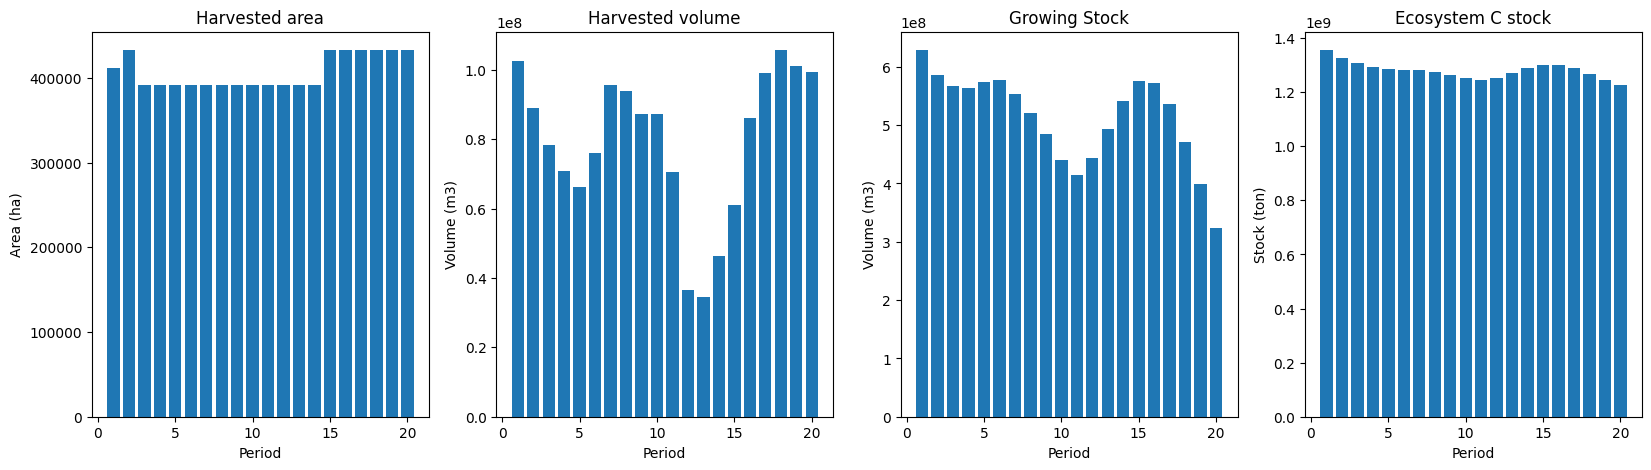

In [47]:
sch = run_scenario(fm,'base_m')

In [ ]:
# %pip install openpyxl

In [ ]:
# sch

In [ ]:
# df = sch[1] 

In [ ]:
# df

In [ ]:
# df.to_excel('results/maintain_aac/sch_ma.xlsx', index=False) 

In [48]:
#Import Module
from util import compile_events

In [49]:
#Define Basic Variables
softwood_volume_yname='swdvol' 
hardwood_volume_yname='hwdvol'
n_yield_vals=100

In [50]:
#Generate New Sit_events file
sit_events = compile_events(fm, softwood_volume_yname, hardwood_volume_yname, n_yield_vals)

In [51]:
# Replace the Sit_events file in the sit tables
sit_tables['sit_events'] = sit_events

In [52]:
sit_events

,theme0,theme1,theme2,theme3,theme4,species,using_age_class,min_softwood_age,max_softwood_age,min_hardwood_age,...,MinSWMerchStemSnagC,MaxSWMerchStemSnagC,MinHWMerchStemSnagC,MaxHWMerchStemSnagC,efficiency,sort_type,target_type,target,disturbance_type,disturbance_year
0,tsa24,1,2401007,100,2401007,softwood,FALSE,-1,-1,-1,...,-1,-1,-1,-1,1,3,A,196.9,harvest,10
1,tsa24,1,2401007,100,2401007,softwood,FALSE,-1,-1,-1,...,-1,-1,-1,-1,1,3,A,1403.2,harvest,10
2,tsa24,1,2401007,100,2401007,softwood,FALSE,-1,-1,-1,...,-1,-1,-1,-1,1,3,A,175.0,harvest,10
3,tsa24,1,2401007,100,2401007,softwood,FALSE,-1,-1,-1,...,-1,-1,-1,-1,1,3,A,508.3,harvest,10
4,tsa24,1,2401007,100,2401007,softwood,FALSE,-1,-1,-1,...,-1,-1,-1,-1,1,3,A,209.6,harvest,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
556,tsa24,1,2403003,304,2423003,softwood,FALSE,-1,-1,-1,...,-1,-1,-1,-1,1,3,A,51498.2,harvest,200
557,tsa24,1,2403003,304,2423003,softwood,FALSE,-1,-1,-1,...,-1,-1,-1,-1,1,3,A,8011.4,harvest,200
558,tsa24,1,2403007,100,2423007,softwood,FALSE,-1,-1,-1,...,-1,-1,-1,-1,1,3,A,21112.0,harvest,200
559,tsa24,1,2403007,100,2423007,softwood,FALSE,-1,-1,-1,...,-1,-1,-1,-1,1,3,A,7881.5,harvest,200


In [53]:
# Run CBM and Generate CBM Ouputs
cbm_output = run_cbm(sit_config, sit_tables, n_steps)

,Biomass,DOM,Ecosystem,All_Emissions,Gross_Growth,Stock_Change
Year,,,,,,
0,4.673542e+08,9.258659e+08,1.393220e+09,0.000000e+00,0.000000e+00,0.000000e+00
1,4.706214e+08,9.239401e+08,1.394562e+09,1.943796e+07,2.077940e+07,-1.341447e+06
2,4.739248e+08,9.222316e+08,1.396156e+09,1.932936e+07,2.092419e+07,-1.594827e+06
3,4.772859e+08,9.207222e+08,1.398008e+09,1.924041e+07,2.109205e+07,-1.851634e+06
4,4.806945e+08,9.193964e+08,1.400091e+09,1.916871e+07,2.125156e+07,-2.082855e+06
...,...,...,...,...,...,...
196,3.452618e+08,9.048843e+08,1.250146e+09,1.656138e+07,1.713505e+07,-5.736705e+05
197,3.485258e+08,9.025361e+08,1.251062e+09,1.643149e+07,1.734733e+07,-9.158407e+05
198,3.518766e+08,9.004481e+08,1.252325e+09,1.632896e+07,1.759175e+07,-1.262789e+06


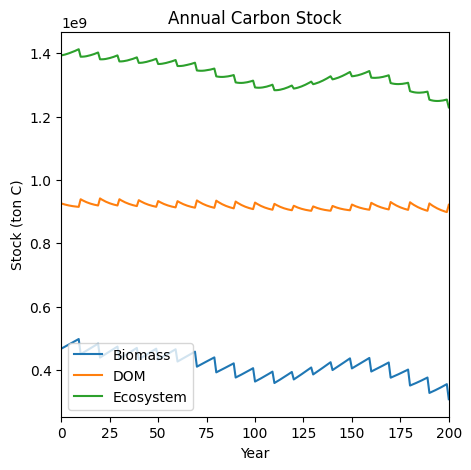

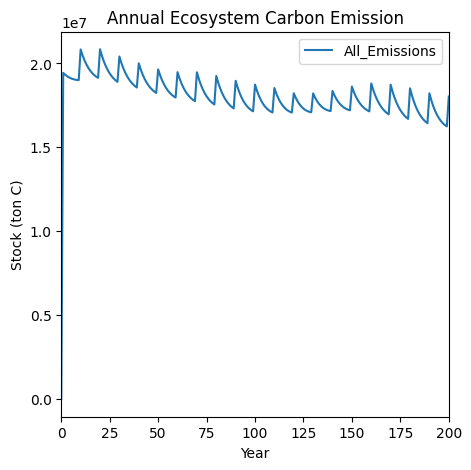

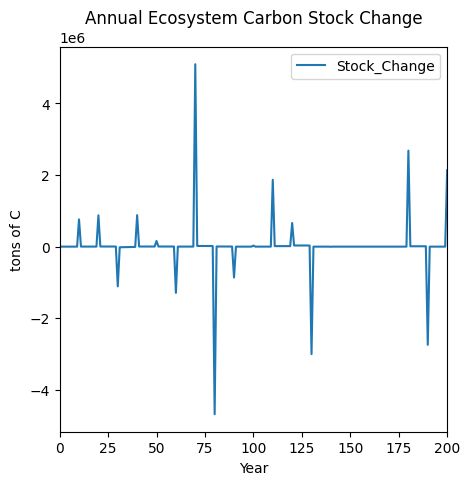

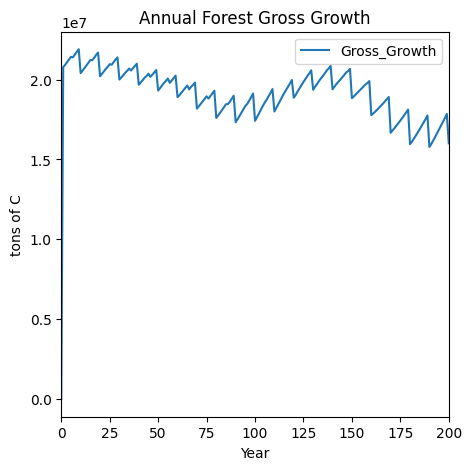

In [54]:
# Report Annual CBM Outputs
cbm_report(fm, cbm_output, biomass_pools, dom_pools, fluxes, gross_growth)

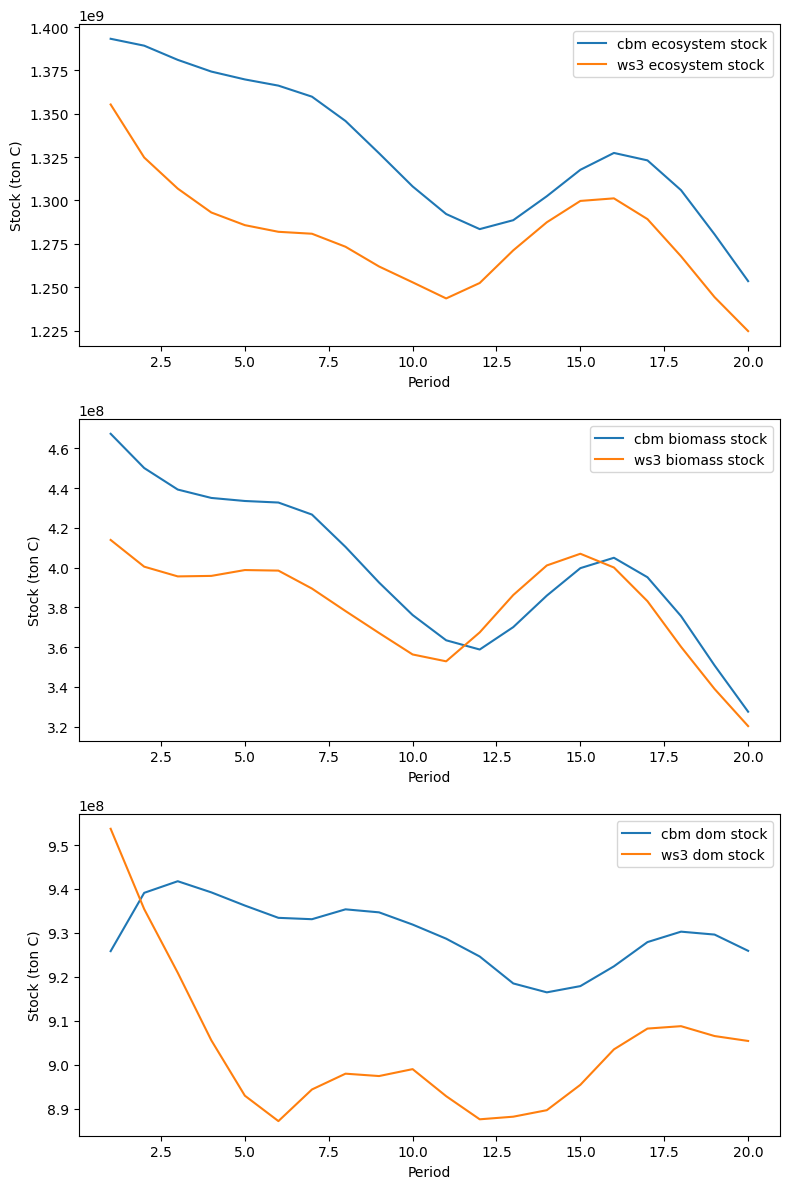

(    period  biomass_stock     dom_stock     eco_stock  eco_stock_change
 0        1   4.673542e+08  9.258659e+08  1.393220e+09      0.000000e+00
 1        2   4.501221e+08  9.391258e+08  1.389248e+09     -3.972168e+06
 2        3   4.393007e+08  9.417656e+08  1.381066e+09     -8.181669e+06
 3        4   4.350859e+08  9.392333e+08  1.374319e+09     -6.747143e+06
 4        5   4.335491e+08  9.362366e+08  1.369786e+09     -4.533504e+06
 5        6   4.327723e+08  9.334408e+08  1.366213e+09     -3.572551e+06
 6        7   4.267159e+08  9.331294e+08  1.359845e+09     -6.367777e+06
 7        8   4.104506e+08  9.353744e+08  1.345825e+09     -1.402035e+07
 8        9   3.925305e+08  9.346883e+08  1.327219e+09     -1.860616e+07
 9       10   3.761925e+08  9.319114e+08  1.308104e+09     -1.911485e+07
 10      11   3.634817e+08  9.287031e+08  1.292185e+09     -1.591912e+07
 11      12   3.588397e+08  9.246477e+08  1.283487e+09     -8.697440e+06
 12      13   3.701125e+08  9.185244e+08  1.288637e

In [55]:
# Compare the carbon outputs from ws3 (table above) and libcbm (table below)
compare_ws3_cbm(fm, cbm_output, disturbance_type_mapping, biomass_pools, dom_pools, fluxes)

(<Figure size 1600x400 with 5 Axes>,
 array([<Axes: title={'center': 'Solid Wood Product C Stock'}, xlabel='Period', ylabel='Stock (tons)'>,
        <Axes: title={'center': 'Paper Product C Stock'}, xlabel='Period', ylabel='Stock (tons)'>,
        <Axes: title={'center': 'Total Product C Stock'}, xlabel='Period', ylabel='Stock (tons)'>,
        <Axes: title={'center': 'Ecosystem C Stock'}, xlabel='Period', ylabel='Stock (tons)'>,
        <Axes: title={'center': 'Total System C Stock'}, xlabel='Period', ylabel='Stock (tons)'>],
       dtype=object),
     period    solid_wood          paper   sum_product     ecosystem  \
 0        1  9.332385e+06  167293.939086  9.499679e+06  1.355339e+09   
 1        2  1.547745e+07  147403.467070  1.562486e+07  1.324769e+09   
 2        3  1.936893e+07  129685.181507  1.949862e+07  1.306844e+09   
 3        4  2.179212e+07  117654.136044  2.190977e+07  1.293075e+09   
 4        5  2.326798e+07  109556.155260  2.337753e+07  1.285775e+09   
 5        6  

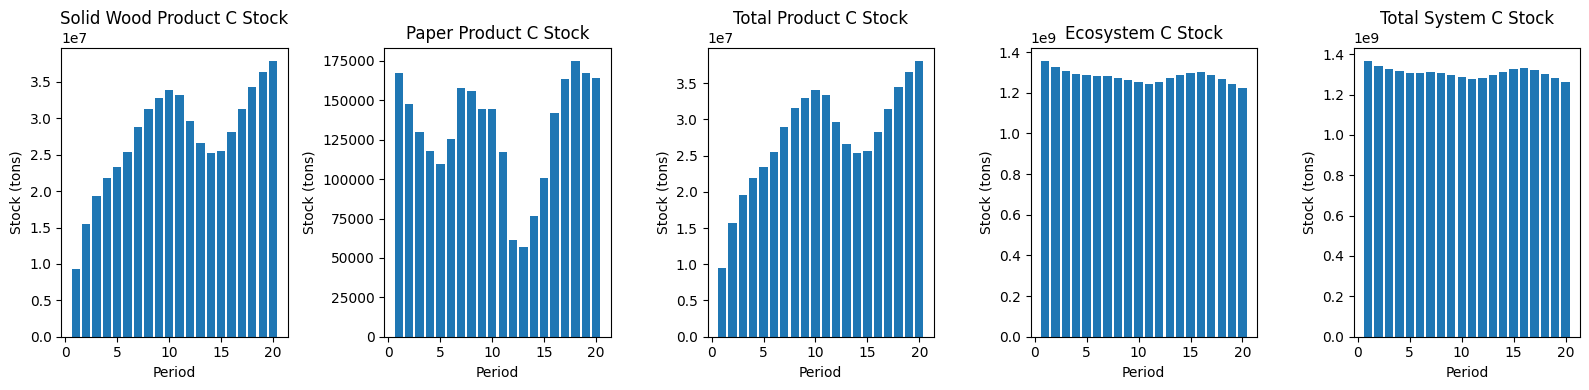

In [56]:
track_system_stock(fm)

In [ ]:
# df_s

In [ ]:
# df_s=df_s[2]

In [ ]:
# df_s

In [ ]:
# df_s.to_excel('results/maintain_aac/stock_ma.xlsx', index=False) 

(<Figure size 1600x400 with 5 Axes>,
 array([<Axes: title={'center': 'Solid Wood Product CO2 Emission'}, xlabel='Period', ylabel='Emission (tons)'>,
        <Axes: title={'center': 'Paper Product CO2 Emission'}, xlabel='Period', ylabel='Emission (tons)'>,
        <Axes: title={'center': 'Total Product CO2 Emission'}, xlabel='Period', ylabel='Emission (tons)'>,
        <Axes: title={'center': 'Ecosystem CO2 Emission'}, xlabel='Period', ylabel='Emission (tons)'>,
        <Axes: title={'center': 'Total System CO2 Emission'}, xlabel='Period', ylabel='Emission (tons)'>],
       dtype=object),
     period    solid_wood         paper   sum_product     ecosystem  \
 0        1  9.988241e+05  1.498236e+07  1.598119e+07  1.052452e+07   
 1        2  1.841642e+06  2.277831e+07  2.461995e+07  3.713474e+07   
 2        3  2.560885e+06  2.631086e+07  2.887175e+07 -2.182362e+05   
 3        4  3.193181e+06  2.756418e+07  3.075736e+07 -9.364992e+06   
 4        5  3.763537e+06  2.767318e+07  3.143672e

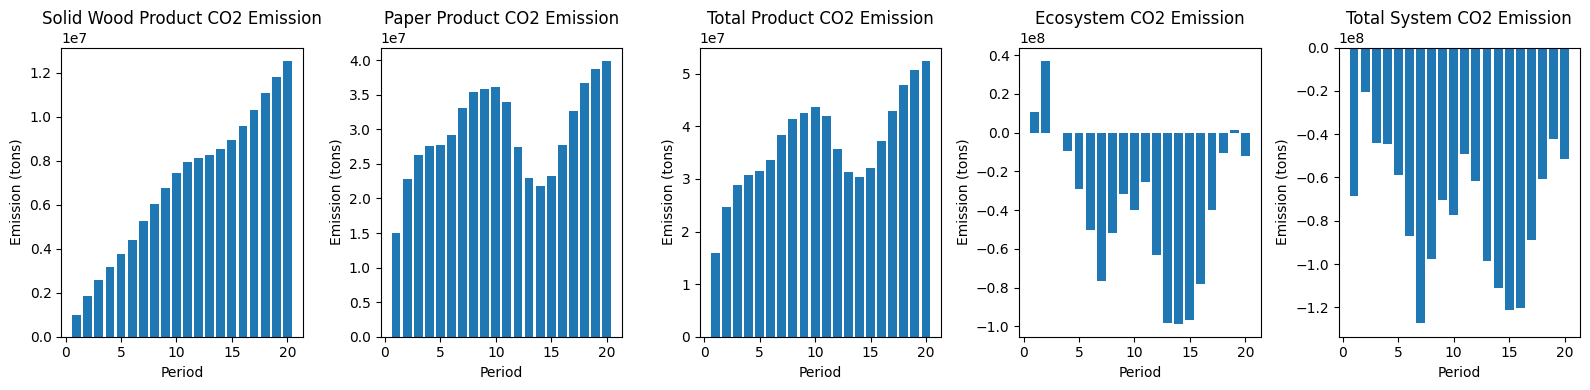

In [57]:
track_system_emission(fm)

In [ ]:
# df_e=df_e[2]

In [ ]:
# df_e

In [ ]:
# df_e.to_excel('results/maintain_aac/emission_ma.xlsx', index=False) 